### Imports

In [1]:
# some imports we will need in this example

import multiDGD
import numpy as np
#import mudata as md
import anndata as ad
import scanpy as sc

### Data loading and preparation

In [2]:
# load some test data

data = ad.read_h5ad('./data/human_bonemarrow/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad')

# this is an example mudata object
data = data[::10,:] # this is just to make it smaller for the demo
print(data)
# set it up with the model (similar to MultiVI)
# but we support both anndata and mudata objects
data = multiDGD.functions._data.setup_data(data, modality_key='feature_types', observable_key='cell_type', covariate_keys=['Site'])
# save this data to keep the train-val-test split for later
data.write_h5ad('./data/human_bonemarrow/example_data.h5ad')

View of AnnData object with n_obs × n_vars = 6925 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'


/usr/local/lib/python3.10/site-packages/multiDGD/functions/_data.py:43: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  data.var['modality'] = modalities


### Initializing and training the model

selected  21  number of Gaussian mixture components based on the provided observable.
Covariate model initialized as:

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
The prepared data consists of the following training set:

        omicsDataset:
            Number of samples: 553
            Modalities: ['GEX', 'ATAC']
            Features per modality: [13431, 116490]
            Total number of features: 129921
            Scaling of values: sum
        
There is also a validation set with 70 samples
And a test set with 70 samples


/usr/local/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:630: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


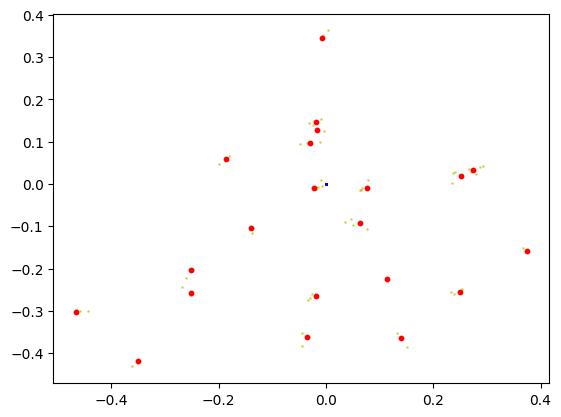

In [6]:
model = multiDGD.DGD(data=data, save_dir="./models", model_name="dgd_bonemarrow_default")
model.view_data_setup()

model.plot_latent_space()

selected  21  number of Gaussian mixture components based on the provided observable.
Covariate model initialized as:

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
The prepared data consists of the following training set:

        omicsDataset:
            Number of samples: 553
            Modalities: ['GEX', 'ATAC']
            Features per modality: [13431, 116490]
            Total number of features: 129921
            Scaling of values: sum
        
There is also a validation set with 70 samples
And a test set with 70 samples


/usr/local/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:630: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


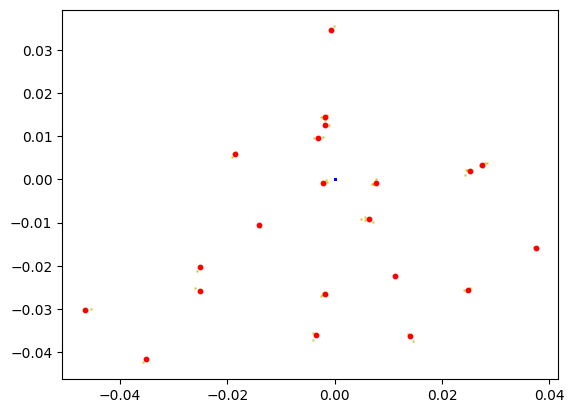

In [16]:
model = multiDGD.DGD(data=data, parameter_dictionary={'softball_scale': 0.1, 'sd_mean':0.0005})
model.view_data_setup()

model.plot_latent_space()

Preparing data loaders
Now training
training for  100  epochs with early stopping ( loss )


Training: 100%|██████████| 100/100 [13:54<00:00,  8.34s/epochs, loss=0.142, reconstruction_loss=0.137]


#######################
Training status
#######################
True


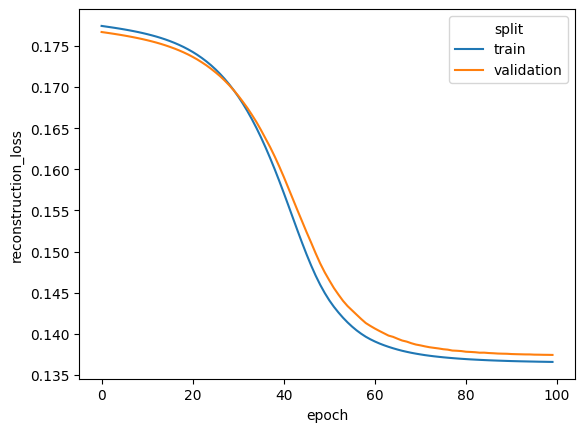

In [9]:
model.train(n_epochs=100)
model.plot_history()

### Visualization and (new) data integration

/usr/local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


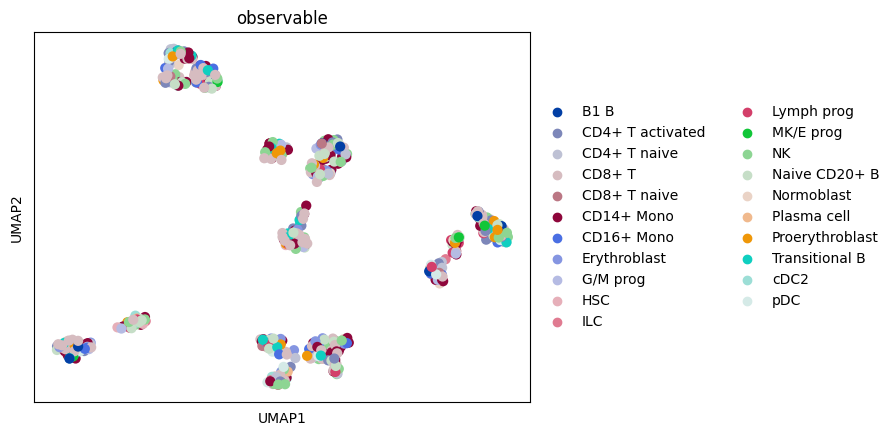

In [10]:
# visualize embeddings (scanpy conform)
# of the training data first

data_train = data.copy()[data.obs['train_val_test'] == 'train']
data_train.obsm['latent'] = model.get_representation()

sc.pp.neighbors(adata=data_train, use_rep='latent')
sc.tl.umap(data_train)
sc.pl.umap(data_train, color='observable')

In [11]:
# now test the held-out data

model.test() # same as model.predict(), all call predict_new() which is the "developer" method

making potential reps
   all potential reps:  torch.Size([84, 22])
calculating losses for each new sample and potential reps
training selected reps for  20  epochs


Training: 100%|██████████| 20/20 [00:25<00:00,  1.26s/epochs, loss=0.139, reconstruction_loss=0.144]


/usr/local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


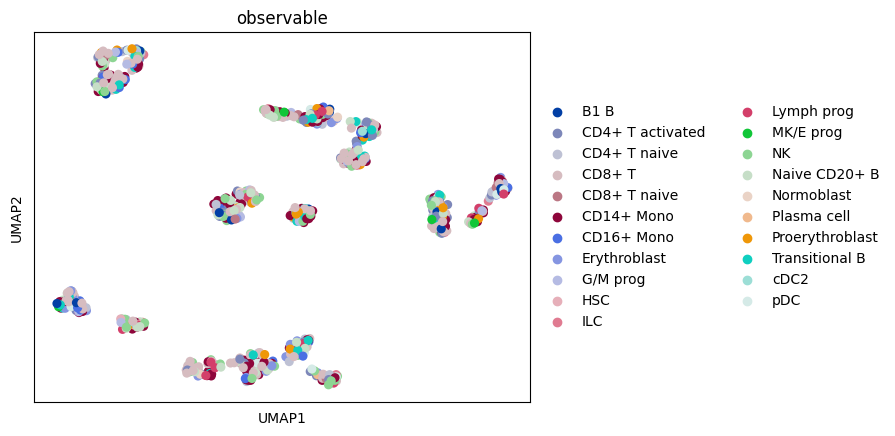

/usr/local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


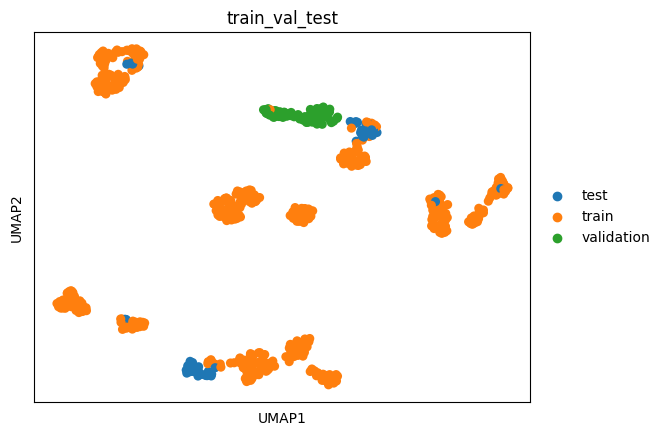

/usr/local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


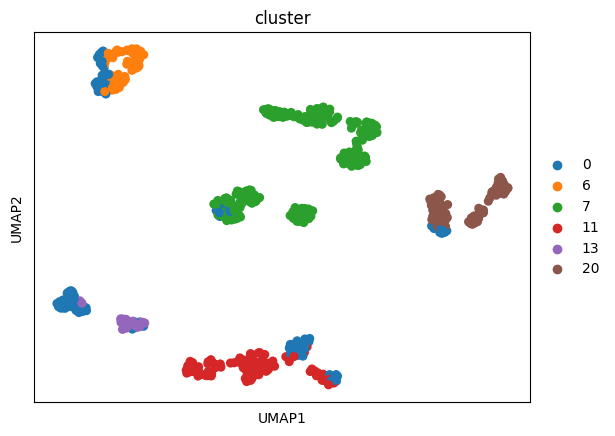

In [12]:
# now visualize the embeddings of all data (train, val, test)
# by cell type, cluster assignment and the data split

data.obsm['latent'] = model.get_representation(split='all')
data.obs['cluster'] = model.clustering(split='all').astype(str)

sc.pp.neighbors(adata=data, use_rep='latent')
sc.tl.umap(data)
sc.pl.umap(data, color='observable')
sc.pl.umap(data, color='train_val_test')
sc.pl.umap(data, color='cluster')

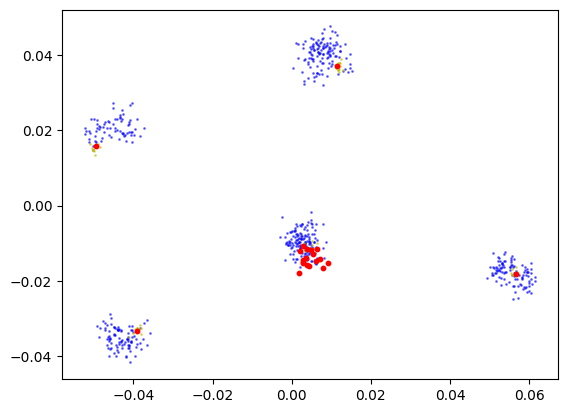

In [13]:
model.plot_latent_space()

Preparing data loaders
Now training
training for  200  epochs with early stopping ( loss )


Training: 100%|██████████| 200/200 [30:01<00:00,  9.01s/epochs, loss=0.138, reconstruction_loss=0.138]


#######################
Training status
#######################
True


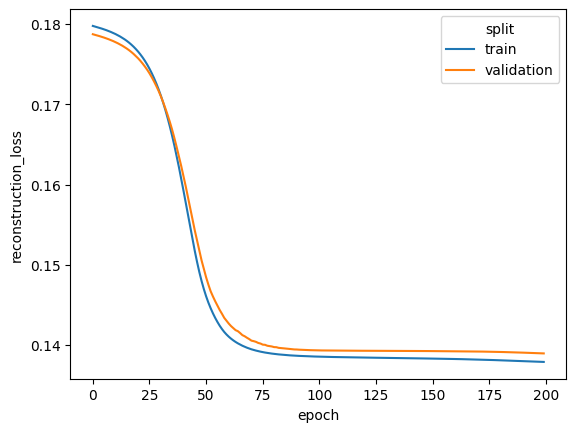

In [17]:
model.train(n_epochs=200)
model.plot_history()

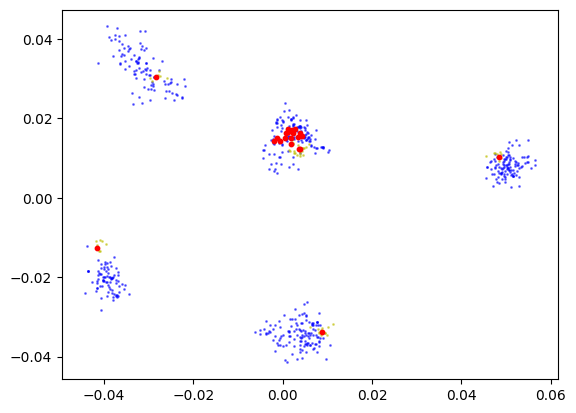

In [18]:
model.plot_latent_space()

In [19]:
model.test()

making potential reps
   all potential reps:  torch.Size([84, 22])
calculating losses for each new sample and potential reps
training selected reps for  20  epochs


Training: 100%|██████████| 20/20 [00:23<00:00,  1.18s/epochs, loss=0.121, reconstruction_loss=0.126]


/usr/local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


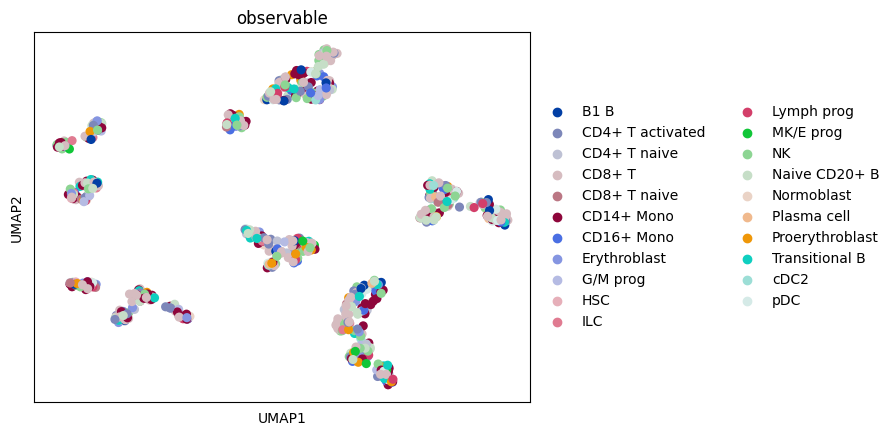

/usr/local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


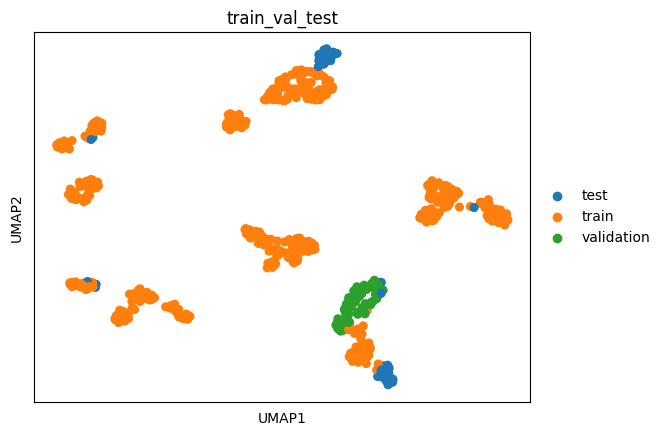

/usr/local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


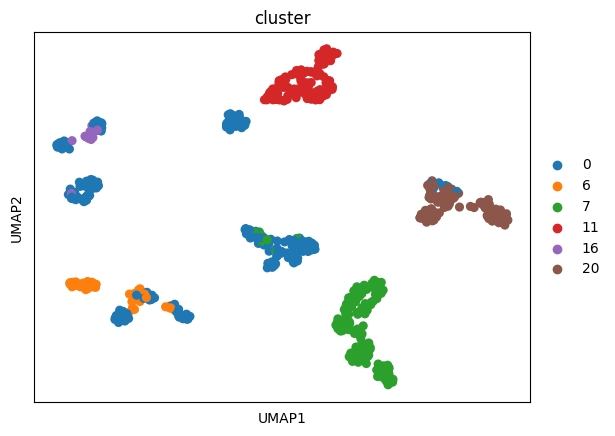

In [20]:
# now visualize the embeddings of all data (train, val, test)
# by cell type, cluster assignment and the data split

data.obsm['latent'] = model.get_representation(split='all')
data.obs['cluster'] = model.clustering(split='all').astype(str)

sc.pp.neighbors(adata=data, use_rep='latent')
sc.tl.umap(data)
sc.pl.umap(data, color='observable')
sc.pl.umap(data, color='train_val_test')
sc.pl.umap(data, color='cluster')

### Model loading

In [4]:
# load model from the saved checkpoint
# models are automaticallt saved after training

model = multiDGD.DGD.load(data=data, save_dir='./', model_name='dgd')

Covariate model initialized as:

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
#######################
Training status
#######################
True


In [5]:
# now test the held-out data

model.test() # same as model.predict(), all call predict_new() which is the "developer" method

making potential reps
   all potential reps:  torch.Size([84, 22])
calculating losses for each new sample and potential reps
training selected reps for  20  epochs


Training: 100%|██████████| 20/20 [00:26<00:00,  1.32s/epochs, loss=0.142, reconstruction_loss=0.138]


/usr/local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


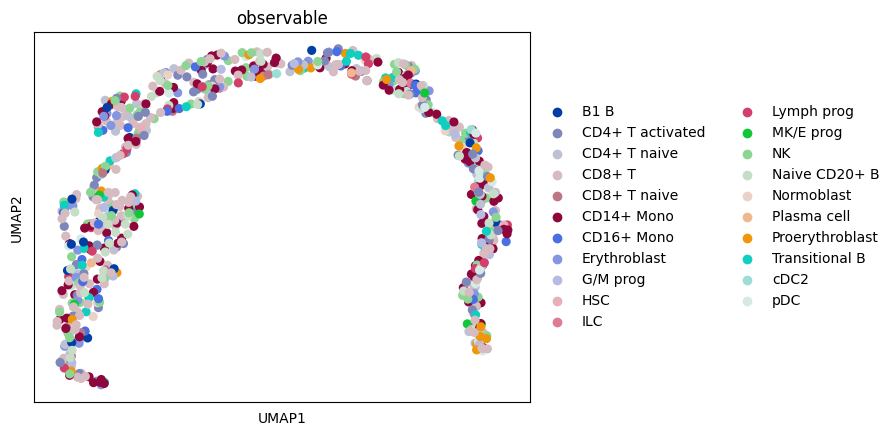

/usr/local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


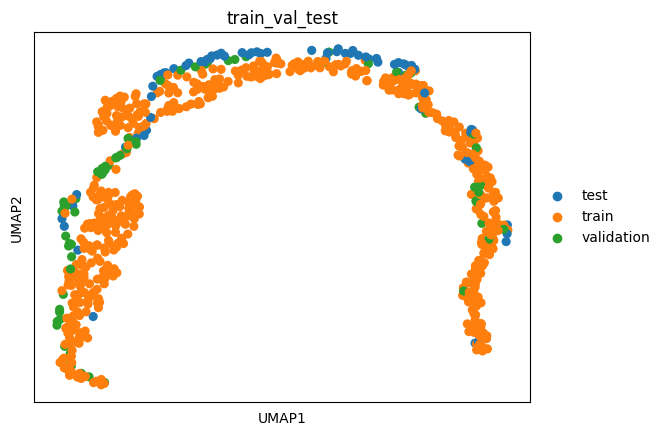

/usr/local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


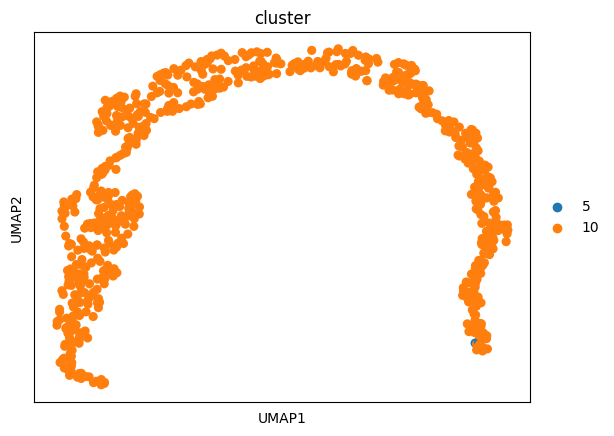

In [6]:
# now visualize the embeddings of all data (train, val, test)
# by cell type, cluster assignment and the data split

data.obsm['latent'] = model.get_representation(split='all')
data.obs['cluster'] = model.clustering(split='all').astype(str)

sc.pp.neighbors(adata=data, use_rep='latent')
sc.tl.umap(data)
sc.pl.umap(data, color='observable')
sc.pl.umap(data, color='train_val_test')
sc.pl.umap(data, color='cluster')

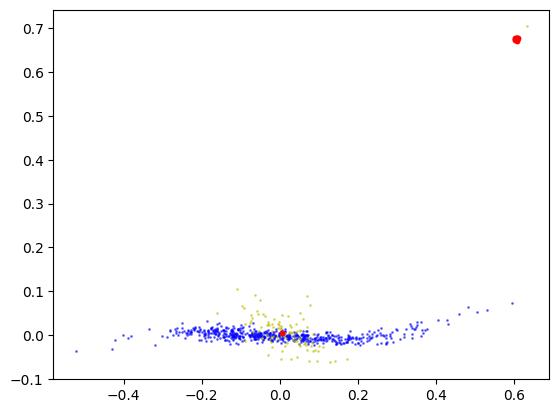

In [12]:
# something is wrong
# plot the rep as PCA and map the gmm means to it

# get the train rep
rep = model.representation.z.detach().numpy()
# do a pca (first import)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(rep)
# transform
rep_pca = pca.transform(rep)
# get the gmm means
gmm_means = model.gmm.mean.detach().numpy()
# transform
gmm_means_pca = pca.transform(gmm_means)
# also do samples from the means
gmm_samples = model.gmm.sample(100).detach().numpy()
gmm_samples_pca = pca.transform(gmm_samples)
# plot
import matplotlib.pyplot as plt
plt.scatter(rep_pca[:,0], rep_pca[:,1], c='b', s=1, alpha=0.5)
plt.scatter(gmm_samples_pca[:,0], gmm_samples_pca[:,1], c='y', s=1, alpha=0.5)
plt.scatter(gmm_means_pca[:,0], gmm_means_pca[:,1], c='r', s=10)
plt.show()

In [7]:
model.gmm.covariance

tensor([[0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
         0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
         0.0004, 0.0004],
        [0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
         0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
         0.0004, 0.0004],
        [0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
         0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
         0.0004, 0.0004],
        [0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
         0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
         0.0004, 0.0004],
        [0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
         0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
         0.0004, 0.0004],
        [0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0